# Differential photometry

* 이 노트북을 구글 코랩에서 실행하고자 한다면 [파일] - [드라이브에 사본 저장]을 하여 본인의 소유로 만든 후에 코드를 실행하거나 수정할 수 있습니다.

* 이 파일은 실제 수업에 사용하므로 필요에 따라 예고 없이 변경될 수 있습니다.

* If you have any questions or comments on this document, please email me(Kiehyun.Park@gmail.com).

* 이 파일(문서)는 공교육 현장에서 수업시간에 자유롭게 사용할 수 있으나, 다른 목적으로 사용할 시에는 사전에 연락을 주셔서 상의해 주시기 바랍니다.



천체 관측 중 CCD(charge couple device) 관측 자료를 이용하여 구경 측광을 수행하는 방법을 다룹니다.

## 필요한 환경



### 한글 폰트 설치 (matplotlib에서 한글 폰트 깨질 경우)

구글 코랩에서 현재의 Jupyter notebook을 실행한다면 matplotlib 그래프에 한글을 사용하기 위해서 폰트를 설치해야 합니다.

아래 코드의 주석을 제거한 후에 셀을 실해 주세요. 그리고 나서 런타임 다시 시작을 해 줘야 matplotlib 그래프에서 한글을 사용할 수 있습니다.

In [40]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

#### 런타임 다시 시작

위의 셀을 실행한 다음 반드시 다음 과정을 수행해야 합니다.

* [메뉴]-[런타임]-[런터임 다시 시작]

* [메뉴]-[런타임]-[이전 셀 실행]

#### 한글 폰트 사용

위에서 한글 폰트를 설치하고, 런타임 다시시작을 했다면 구글 코랩에서 폰트 경로를 설정하여 한글 사용이 가능해 집니다.

In [41]:
#visualization
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

plt.rcParams.update({'figure.max_open_warning': 0})

import warnings
warnings.filterwarnings('ignore')

### 모듈 설치 및 버전 확인

아래 셀을 실행하면 이 노트북을 실행하는데 필요한 모듈을 설치하고 파이썬 및 관련 모듈의 버전을 확인할 수 있습니다.

In [42]:
!pip install photutils==1.12
# !pip install astropy==6.1

In [43]:
import importlib, sys, subprocess
packages = "numpy, matplotlib, astropy, photutils, astroquery, ysfitsutilpy, ysphotutilpy, sep, aplpy, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        print(f"**** {pkg} module is now being installed.")
    else:
        print(f"******** {pkg} module is already installed.")
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

******** numpy module is already installed.
******** matplotlib module is already installed.
******** astropy module is already installed.
******** photutils module is already installed.
******** astroquery module is already installed.
******** ysfitsutilpy module is already installed.
******** ysphotutilpy module is already installed.
******** sep module is already installed.
******** aplpy module is already installed.
******** version_information module is already installed.
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2024-10-07 14:34:48 (UTC = GMT+0000) 
0 Python     3.10.12 64bit [GCC 11.4.0]
1 IPython    7.34.0
2 OS         Linux 6.1.85+ x86_64 with glibc2.35
3 numpy      1.26.4
4 matplotlib 3.7.1
5 astropy    6.1.4
6 photutils  1.12.0
7 astroquery 0.4.7
8 ysfitsutilpy 0.2
9 ysphotutilpy 0.1.1
10 sep        1.2.1
11 aplpy      2.1.0
12 version_information 1.0.4


## 데이터 저장

### FITS 파일 저장 폴더 생성

FITS 파일을 저장할 폴더를 "aper_photometry" 이라는 이름으로 생성해 보겠습니다.

* 만약 리눅스 시스템 이라면 shell 명령어로 가능한데, "!"를 붙이면 shell 명령어를 실행할 수 있습니다.
> !mkdir aper_photometry

OS의 영향을 받지 않기 위하여 pathlib을 사용하여 폴더를 생성하겠습니다.

In [44]:
import os
from pathlib import Path
BASEPATH = Path("./")
save_dir_name = "aper_photometry"
print(f"BASEPATH: {BASEPATH}")

if not (BASEPATH/save_dir_name).exists():
    os.mkdir(str(BASEPATH/save_dir_name))
    print (f"{str(BASEPATH/save_dir_name)} is created...")
else :
    print (f"{str(BASEPATH/save_dir_name)} is already exist...")

BASEPATH: .
aper_photometry is already exist...


### FITS 파일 다운로드

나의 구글 드라이브에 저장된 CCD 관측 파일을 다운받아 보겠습니다.

GNU Wget은 HTTP 통신 또는 FTP 통신을 사용해 서버에서 파일 또는 콘텐츠를 다운로드할 때 사용하는 소프트웨어입니다. Wget의 특징은 여러 파일을 한 번에 다운로드하거나 웹 페이지의 링크를 순회하며 여러 콘텐츠를 자동으로 다운로드할 때 매우 편리합니다.

MS Windows에서는 별도로 설치를 해줘야 하며,
구글 코랩도 wget을을 지원해주니 아래 셀을 실행하면 자신의 [작업 영역]에 저장된다. 하지만 이 파일은 이 런타임이 재실행 될때는 삭제됨에 유의하시기 바랍니다.

아래 코드를 실행하면 여러분의 작업영역에 해당 파일을 저장해 줄 것입니다.



In [45]:
fname = "TrES-4b_LIGHT_R_2024-06-13-15-09-52_120sec_GSON300_STF-8300M_-10c_1bin.fit"
fid = "19Y2TMjSFUgldAWiXftpHHcFZ7N92ebhP"

# wget을 이용(나의 구글드라이브에서 공유한 파일을 사용할 경우)
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid}" -O {save_dir_name}/{fname}


--2024-10-07 14:34:48--  https://docs.google.com/uc?export=download&id=19Y2TMjSFUgldAWiXftpHHcFZ7N92ebhP
Resolving docs.google.com (docs.google.com)... 108.177.98.139, 108.177.98.100, 108.177.98.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.98.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=19Y2TMjSFUgldAWiXftpHHcFZ7N92ebhP&export=download [following]
--2024-10-07 14:34:49--  https://drive.usercontent.google.com/download?id=19Y2TMjSFUgldAWiXftpHHcFZ7N92ebhP&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.117.132, 2607:f8b0:400e:c0a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.117.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33958080 (32M) [application/octet-stream]
Saving to: ‘aper_photometry/TrES-4b_LIGHT_R_2024-06-13-15-09-52_120sec_GSON300_STF-8300M_-10c_1b

### 데이터 확인

* 코랩을 사용할 경우에는 오른쪽의 [파일]창에서 확인할 수 있습니다.
* linux shell 명령어로 다음과 같이 확인해 볼 수 있습니다.
> !ls -l apert_photometry

OS의 영향을 받지 않고 파이썬으로 확인하는 방법은 아래와 같이 하면 됩니다.

In [46]:
fpaths = sorted(list((BASEPATH/save_dir_name).glob('*.fit*')))
print(f"fpaths: {fpaths}")
print(f"len(fpaths): {len(fpaths)}")

fpaths: [PosixPath('aper_photometry/TrES-4b_LIGHT_R_2024-06-13-15-09-52_120sec_GSON300_STF-8300M_-10c_1bin.fit')]
len(fpaths): 1


##  FITS handling

### Load files

fits file을  읽어 확인해 보겠습니다.

In [47]:
from astropy.io import fits
import ysfitsutilpy as yfu
fpath = Path(fpaths[0])

hdul = fits.open(fpath, unit="adu")
ccd = yfu.load_ccd(fpath)
flt = hdul[0].header["filter"]

print("type(hdul) :", type(hdul))
print("type(hdul[0]) :", type(hdul[0]))

type(hdul) : <class 'astropy.io.fits.hdu.hdulist.HDUList'>
type(hdul[0]) : <class 'astropy.io.fits.hdu.image.PrimaryHDU'>


### header

hdul 이라는 이름에 HDUList들이 리스트 형태로 들어 있습니다. 각각의 hdulist는 2차원 이므로 index는 [0]번만 존재합니다.

In [48]:
print("type(hdul[0].hedaer) :", type(hdul[0].header))
hdul[0].header

type(hdul[0].hedaer) : <class 'astropy.io.fits.header.Header'>


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3352                                                  
NAXIS2  =                 2532                                                  
FITS-TLM= '2024-07-09T04:33:31' / UT of last modification of this FITS file     
IMAGETYP= 'LIGHT'              / Type of exposure                               
EXPOSURE=                120.0 / [s] Exposure duration                          
EXPTIME =                120.0 / [s] Exposure duration                          
DATE-LOC= '2024-06-14T00:09:52.375' / Time of observation (local)               
DATE-OBS= '2024-06-13T15:09:52.375' / Time of observation (UTC)                 
DATE-AVG= '2024-06-13T15:10:52.684' / Averaged midpoint time (UTC)              
XBINNING=                   

header는 key와 value가 들어 있습니다.

In [49]:
print("hdul[0].hedaer['DATE-OBS'] :", hdul[0].header['DATE-OBS'])
print("type(hdul[0].hedaer['DATE-OBS']) :", type(hdul[0].header['DATE-OBS']))

hdul[0].hedaer['DATE-OBS'] : 2024-06-13T15:09:52.375
type(hdul[0].hedaer['DATE-OBS']) : <class 'str'>


### data

관측 자료는 numpy.ndarray 형태로 들어 있음을 알 수 있습니다.

In [50]:
print("type(hdul[0].data) :", type(hdul[0].data))
print("hdul[0].data.dtype :", hdul[0].data.dtype)
print("hdul[0].data.shape :", hdul[0].data.shape)
print("hdul[0].data :", hdul[0].data)

type(hdul[0].data) : <class 'numpy.ndarray'>
hdul[0].data.dtype : >f4
hdul[0].data.shape : (2532, 3352)
hdul[0].data : [[5067.6787 5037.07   5060.528  ... 4894.813  5009.1943 5037.396 ]
 [4936.9307 4898.719  4789.0527 ... 5115.048  4923.348  4852.493 ]
 [4985.832  4864.455  4921.625  ... 4921.9062 4787.201  4860.65  ]
 ...
 [4991.9736 4992.8037 4915.1733 ... 5025.4897 4829.709  5017.197 ]
 [4783.4727 4921.0396 4927.37   ... 4990.7505 4877.3276 5066.698 ]
 [5076.9834 4831.114  4855.544  ... 5191.9385 5118.3633 5091.164 ]]


## 별 찾기 (Finding stars)

### 관측소, 관측 장비 설정

In [51]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u

#####################################################################
# Observed location
LOCATION = dict(lon=127.005, lat=37.308889, elevation=101)
Suwon = location = EarthLocation(lon=127.005 * u.deg,
                                 lat=37.308889 * u.deg,
                                 height=101 * u.m)
MPC_obscode = "P64"
#######################################################
# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')

#######################################################
# optic and ccd
if hdul[0].header["CCDNAME"] == "STF-8300M" :
    gain = 0.37
    rdnoise = 9.3
    pix_size = 5.4 * u.um

if hdul[0].header["CCDNAME"] == "STX-16803" :
    gain = 1.27
    rdnoise = 9.0
    pix_size = 9 * u.um

if hdul[0].header["OPTIC"] == "GSON300" :
    focal_length = 1200 * u.mm

if hdul[0].header["OPTIC"] == "RiLA600" :
    focal_length = 3000 * u.mm

print("rdnoise, gain, pix_size, focal_length :", rdnoise, gain, pix_size, focal_length)


#######################################################
# PIXSCALE
if 'PIXSCALE' in hdul[0].header:
    PIX2ARCSEC = hdul[0].header['PIXSCALE']
else :
    PIX2ARCSEC = 206265 * hdul[0].header['XPIXSZ'] ( hdul[0].header['XBINNING']  * hdul[0].header['FOCALLEN'])

PIX2ARCSEC = PIX2ARCSEC # * u.arcsec / u.pixel
print("PIX2ARCSEC :", PIX2ARCSEC)

rdnoise, gain, pix_size, focal_length : 9.3 0.37 5.4 um 1200.0 mm
PIX2ARCSEC : 0.9281925000000001


### 관측 시각 얻기

In [52]:
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astroquery.jplhorizons import Horizons

# D.2. Find the observation time and exposure time to set the obs time
t_start = Time(hdul[0].header['DATE-OBS'], format='isot')
t_expos = hdul[0].header['EXPTIME'] * u.s
t_middle = t_start + t_expos / 2 # start time + 0.5 * exposure time

print(f"t_start: {t_start}, t_expos: {t_expos}, t_middle: {t_middle}")

t_start: 2024-06-13T15:09:52.375, t_expos: 120.0 s, t_middle: 2024-06-13T15:10:52.375


### def zimshow

In [53]:
from warnings import warn
from astropy.visualization import (
    ImageNormalize,
    LinearStretch,
    ZScaleInterval,
    simple_norm,
)

def znorm(image, stretch=LinearStretch(), **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs), stretch=stretch)

def zimshow(
    ax,
    image,
    stretch=LinearStretch(),
    cmap=None,
    origin="lower",
    zscale_kw={},
    **kwargs
):
    im = ax.imshow(
        image,
        norm=znorm(image, stretch=stretch, **zscale_kw),
        origin=origin,
        cmap=cmap,
        **kwargs
    )
    return im

def norm_imshow(
    ax,
    data,
    origin="lower",
    stretch="linear",
    power=1.0,
    asinh_a=0.1,
    min_cut=None,
    max_cut=None,
    min_percent=None,
    max_percent=None,
    percent=None,
    clip=True,
    log_a=1000,
    invalid=-1.0,
    zscale=False,
    vmin=None,
    vmax=None,
    **kwargs
):
    """Do normalization and do imshow"""
    if vmin is not None and min_cut is not None:
        warn("vmin will override min_cut.")

    if vmax is not None and max_cut is not None:
        warn("vmax will override max_cut.")

    if zscale:
        zs = ImageNormalize(data, interval=ZScaleInterval())
        min_cut = vmin = zs.vmin
        max_cut = vmax = zs.vmax

    if vmin is not None or vmax is not None:
        im = ax.imshow(data, origin=origin, vmin=vmin, vmax=vmax, **kwargs)
    else:
        im = ax.imshow(
            data,
            origin=origin,
            norm=simple_norm(
                data=data,
                stretch=stretch,
                power=power,
                asinh_a=asinh_a,
                min_cut=min_cut,
                max_cut=max_cut,
                min_percent=min_percent,
                max_percent=max_percent,
                percent=percent,
                clip=clip,
                log_a=log_a,
                invalid=invalid
            ),
            **kwargs)
    return im


## PS1 catalogue


### check solve

In [54]:
#########################################
# checkPSolve
#########################################
def checkPSolve(fpath,
                    **kwargs,
                    ):
    """
    Parameters
    ----------
    fpath : path-like
        The path to the original FITS file.

    return
    ----------
    SOLVE, ASTAP, LOCAL :  bool, bool, bool

    """

    fpath = Path(fpath)
    hdul = fits.open(fpath)
    PSKeys = ["CD1_1", "CD1_2", "CD2_1", "CD2_2",
              "A_0_0", "A_0_1", "A_1_0","A_1_1",
              "PC1_1", "PC1_2", "PC2_1", "PC2_2", ]

    chk = 0
    SOLVE = False
    ASTAP = False
    LOCAL = False

    for PSKey in PSKeys :
        if PSKey in hdul[0].header :
            chk += 1
    if chk > 3 :
        SOLVE = True
        LOCAL = False
        ASTAP = False
        try :
            for comment in hdul[0].header["COMMENT"]:
                if "scale:" in comment :
                    LOCAL = True
        except :
            LOCAL = False

        if "PLTSOLVD" in hdul[0].header:
            try :
                ASTAP = hdul[0].header["PLTSOLVD"]
            except :
                ASTAP = False
    else :
        SOLVE = False
        ASTAP = False
        LOCAL = False
    hdul.close()

    return SOLVE, ASTAP, LOCAL

SOLVE, ASTAP, LOCAL = checkPSolve(str(fpath))
print("SOLVE, ASTAP, LOCAL :", SOLVE, ASTAP, LOCAL)

SOLVE, ASTAP, LOCAL : True True False


### WCS

In [55]:
from astropy.wcs import WCS

wcs = WCS(hdul[0].header)
print("wcs :", wcs)
print("type(wcs) :", type(wcs))
print("dir(wcs) :", dir(wcs))

wcs.pixel_n_dim

wcs : WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 268.3377443919 37.21877698979 
CRPIX : 1676.5 1266.5 
CD1_1 CD1_2  : -0.0002547589887815 -2.194419351265e-06 
CD2_1 CD2_2  : 2.099373447175e-06 -0.000254774569423 
NAXIS : 3352  2532
type(wcs) : <class 'astropy.wcs.wcs.WCS'>
dir(wcs) : ['__abstractmethods__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_all_pix2world', '_all_world2pix', '_array_converter', '_as_mpl_axes', '_denormalize_sky', '_det2im', '_fix_ctype', '_fix_pre2012_scamp_tpv', '_fix_scamp', '_get_components_and_classes', '_get_naxis', '_init_kwargs', '_naxis', '_normalize_sky', '

2

중심의 좌표는 다음과 같이 얻을 수 있다.

In [56]:
import ysfitsutilpy as yfu
# Get the radius of the smallest circle which encloses all the pixels
rad = yfu.fov_radius(header=hdul[0].header,
                    unit=u.deg)
print("rad: {}".format(rad))  # 시야각(FOV)으로 구한 반지름

cent_coord = yfu.center_radec(ccd_or_header=hdul[0].header,
                                      center_of_image=True)
print("cent_coord: {}".format(cent_coord))

pos_sky = SkyCoord(cent_coord, unit='deg')
pos_pix = pos_sky.to_pixel(wcs=wcs)

print("pos_sky: {}".format(pos_sky))
print("pos_pix: {}".format(pos_pix))

rad: 0.3225442103070641 deg
cent_coord: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (268.33774439, 37.21877699)>
pos_sky: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (268.33774439, 37.21877699)>
pos_pix: (array(1675.5), array(1265.5))


### query

In [57]:
import numpy as np

#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
FWHM = FWHM_INIT
R_AP = 1.5*FWHM_INIT # Aperture radius
R_IN = 4*FWHM_INIT   # Inner radius of annulus
R_OUT = 6*FWHM_INIT  # Outer radius of annulus

from photutils import detect_threshold
thresh_snr = detect_threshold(data=hdul[0].data, nsigma=3,)
# print('type(thresh_snr) :', type(thresh_snr))
# print('thresh_snr.shape :', thresh_snr.shape)
# print('detect_threshold', thresh_snr)
thresh = thresh_snr[0][0]

Mag_Low = 11.5
Mag_High = 15

Mag_target = 12.5
Mag_delta = 2
ERR_Min = 0.5
#######################################################
import ysphotutilpy as ypu

ps1 = ypu.PanSTARRS1(cent_coord.ra, cent_coord.dec, radius=rad,
                        column_filters={"rmag":f"{Mag_target-Mag_delta}..{Mag_target+Mag_delta}",
                        "e_rmag":"<0.10", "nr":">5"}
                        )
PS1_stars_all = ps1.query()
print("type(PS1_stars_all) :", type(PS1_stars_all))
print("len(PS1_stars_all) :", len(PS1_stars_all))


type(PS1_stars_all) : <class 'astropy.table.table.Table'>
len(PS1_stars_all) : 74


결과는 astropy.table로 반환되며 pandas dataframe으로 변환이 가능하다. 아래는 query의 결과 얻은 모든 별의 목록이다.

In [58]:
df_stars_all = PS1_stars_all.to_pandas()
print("type(df_stars_all) :", type(df_stars_all))
print("len(df_stars_all) :", len(df_stars_all))
df_stars_all

type(df_stars_all) : <class 'pandas.core.frame.DataFrame'>
len(df_stars_all) : 74


,_r,RAJ2000,DEJ2000,objID,cell,sky,f_objID,Qual,e_RAJ2000,e_DEJ2000,...,yPSFf,ymag,e_ymag,ymagStd,o_ymag,b_ymag,B_ymag,yKmag,e_yKmag,yFlags
0,0.045625,268.290172,37.193371,152632682901882678,2139,38,503635968,60,0.0075,0.0061,...,0.999108,13.1442,0.0052,0.0115,5,13.1268,13.1470,13.1518,0.0056,115000
1,0.048102,268.386582,37.247103,152692683866047157,2139,38,503635968,60,0.0152,0.0234,...,0.999587,13.7628,0.0025,0.0086,7,13.7445,13.7711,13.7859,0.0021,115000
2,0.049677,268.346740,37.267941,152722683467322162,2139,38,503635968,60,0.0044,0.0179,...,0.999191,13.9179,0.0019,0.0050,7,13.9150,13.9281,13.9184,0.0023,115000
3,0.064869,268.329711,37.154230,152582683296435721,2139,28,503635968,60,0.0038,0.0034,...,0.999709,13.9320,0.0061,0.0167,9,13.9168,13.9689,13.9617,0.0056,115000
4,0.096714,268.302956,37.126127,152552683029681993,2139,28,503635968,60,0.0039,0.0077,...,0.999704,13.7628,0.0071,0.0186,9,13.7345,13.7929,13.7878,0.0037,115000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.316288,268.482374,37.513445,153012684823616751,2139,37,503635968,60,0.0057,0.0038,...,0.999724,14.2227,0.0026,0.0182,9,14.2035,14.2683,14.2512,0.0032,115000
70,0.317051,268.587033,36.971831,152362685870446826,2139,27,503635968,60,0.0095,0.0033,...,0.999148,14.0156,0.0035,0.0134,10,13.9956,14.0291,14.0349,0.0045,115000
71,0.317655,268.399674,37.532602,153032683996969731,2139,38,503635968,60,0.0011,0.0019,...,0.999777,14.0610,0.0035,0.0220,8,14.0300,14.1009,14.0743,0.0019,115000
72,0.320578,268.146034,37.500828,153002681460511613,2139,38,503635968,60,0.0016,0.0040,...,0.998883,14.0760,0.0027,0.0159,11,14.0311,14.0855,14.0914,0.0030,115000


### is near

가까이 있는 별 등 비교 측광에 방해되는 별을 제거하자.

In [59]:
df_stars_all = df_stars_all.dropna(subset=["gmag", "rmag"])
print(df_stars_all.columns)

isnear = ypu.organize_ps1_and_isnear(
                    ps1,
                    ccd.header+ccd.wcs.to_header(),
                    bezel=5*FWHM_INIT*PIX2ARCSEC,
                    nearby_obj_minsep=5*FWHM_INIT*PIX2ARCSEC,
                    group_crit_separation=6*FWHM_INIT
                )

df_stars = ps1.queried.to_pandas()
print("len(df_stars):", len(df_stars))
df_stars = df_stars.dropna(subset=["gmag", "rmag"])
print("len(df_stars):", len(df_stars))

Index(['_r', 'RAJ2000', 'DEJ2000', 'objID', 'cell', 'sky', 'f_objID', 'Qual',
       'e_RAJ2000', 'e_DEJ2000', '_tab1_10', 'Ns', 'Nd', 'Ng', 'Nr', 'Ni',
       'Nz', 'Ny', 'gPSFf', 'gmag', 'e_gmag', 'gmagStd', 'o_gmag', 'b_gmag',
       'B_gmag', 'gKmag', 'e_gKmag', 'gFlags', 'rPSFf', 'rmag', 'e_rmag',
       'rmagStd', 'o_rmag', 'b_rmag', 'B_rmag', 'rKmag', 'e_rKmag', 'rFlags',
       'iPSFf', 'imag', 'e_imag', 'imagStd', 'o_imag', 'b_imag', 'B_imag',
       'iKmag', 'e_iKmag', 'iFlags', 'zPSFf', 'zmag', 'e_zmag', 'zmagStd',
       'o_zmag', 'b_zmag', 'B_zmag', 'zKmag', 'e_zKmag', 'zFlags', 'yPSFf',
       'ymag', 'e_ymag', 'ymagStd', 'o_ymag', 'b_ymag', 'B_ymag', 'yKmag',
       'e_yKmag', 'yFlags'],
      dtype='object')
 64 objects remaining:  10 masked out of  74 based on [27.845775 27.845775]-pixel bezel.
 62 objects remaining:   2 masked out of  64 based on DAOGROUP with 36.000-pixel critical separation..
 62 objects remaining:   0 masked out of  62 based on f_objID ([0, 1, 2, 3

### WCS to pixel address

별의 좌표를 픽셀 좌표로 변환할 수 있다.

In [60]:
import numpy as np

pos_stars_all = np.array([df_stars_all["RAJ2000"].array, df_stars_all["DEJ2000"].array]).T
pos_stars_all = SkyCoord(pos_stars_all, **SKYC_KW).to_pixel(wcs)
pos_stars_all = np.transpose(pos_stars_all)
# pos_stars_all   # PS1 query 모든 별

pos_stars = np.array([df_stars["RAJ2000"].array, df_stars["DEJ2000"].array]).T
pos_stars = SkyCoord(pos_stars, **SKYC_KW).to_pixel(wcs)
pos_stars = np.transpose(pos_stars)
# pos_stars     # PS1 query 중 비교 측광에 사용될 별

### set aperture and annulus

In [61]:
from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
ap_stars = CAp(positions=pos_stars, r=R_IN)
ap_stars_all = CAp(positions=pos_stars_all, r=R_IN)
#apert
an_stars = CAn(positions=pos_stars, r_in=R_IN, r_out=R_OUT)
an_stars_all = CAn(positions=pos_stars_all, r_in=R_IN, r_out=R_OUT)
#annul

### tag stars on image

흰색 tag는 is near에서 지워진 별들이고, 붉은색 tag이 비교 측광에 사용될 별들 입니다.

In [62]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(12, 8),
                        subplot_kw={'projection': wcs},
                        sharex=False, sharey=False, gridspec_kw=None)

im = zimshow(axs, hdul[0].data, )
axs.coords.grid(True, color='white', ls=':')
axs.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
axs.coords['ra'].set_ticklabel_position('bl')
axs.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
axs.coords['dec'].set_ticklabel_position('bl')
axs.coords['ra'].set_major_formatter('hh:mm')
axs.coords['dec'].set_major_formatter('dd:mm')
axs.coords['ra'].display_minor_ticks(True)
axs.coords['dec'].display_minor_ticks(True)
axs.coords['ra'].set_minor_frequency(2)
axs.coords['dec'].set_minor_frequency(2)
axs.tick_params(labelsize=8)

for i in range(len(pos_stars)):
    axs.text(pos_stars[i][0], pos_stars[i][1], f"Star #{str(i)}", fontsize=6, color='w')

ap_stars_all.plot(axs, color='w', lw=1)
ap_stars.plot(axs, color='r', lw=1)

axs.set_title(f"fname: {fpath.name}\n Comparison Stars of PS1 (red tag, Magnitude : {Mag_target}+-{Mag_delta})", fontsize=10,)

cbar = plt.colorbar(im, ax = axs, fraction=0.035, pad=0.04, )
cbar.ax.tick_params(labelsize=8)

axs.annotate(f'Number of star(s): {len(pos_stars)}', fontsize=8,
    xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{save_dir_name}/{fpath.stem}_PS1_comparison.png")

plt.show()
#plt.close()

Output hidden; open in https://colab.research.google.com to view.

## 표준화

$M_f=m_f+(\text { effect of atmosphere })+(\text { effect of CCD }) \approx m_f-k_f^{\prime} X-k_f^{\prime \prime} X C+z_f+k_f C$

- $f$ : 필터 ( $\mathrm{V}, \mathrm{B}, \mathrm{R}, \mathrm{g}, \mathrm{r}, \mathrm{i}$ 등).
- X: airmass (간단하게 천정거리를 이용하여  $\sec Z$ 로 구함).
- $M_f$ : 필터  $f$의 표준화를 통해 변환한 등급
- $m_f$ : 필터  $f$의 기기 등급 ( $m_f=-2.5 \lg N$ ).
- $C$ : 색지수, 예를 들면 $B-V$ or $r^{\prime}-i^{\prime}$ (필터 $f$를 포함할 필요는 없으나 색지수를 구한 두 파장의 범위 안에 $f$가 포함되는 것이 권장됨.)
- $k_f^{\prime}$ : 필터  $f$에서의 1차 소광 계수 (단순하게 어두워 지는 정도).
- $k_f^{\prime \prime}$ : 필터 $f$의 2차 소광 계수 (색에 따라 어두워 지는 정도).
- $z_f$ : 필터 $f$의 제로 포인트(zero point).
- $k_f$ : 필터 $f$의 변환 계수.

비교 측광에서는 간단히 다음과 같이 구할 수 있습니다.
$$ m_f = M_f + Z $$
$Z$는 제로 포인트(zero point)로 상수 값입니다. (즉 같은 이미지에서 airmass $X$는 같다고 가정하고, 색지수는 무시할만하다는 것을 보일 것입니다.)

### 필터 변환

Pan-STARRS의 측광계는 g, r, i, z, y 입니다. 우리는 UBVRI 측광계 (Johnson Cousins wideband UBVRI filter)를 사용하였기 때문에 측광 값을 알맞게 변환해 줄 필요가 있습니다.
Tonry et. al.(2012)의 연구결과에 따르면 B, V, R 필터와 g, r 필터 사이에는 다음과 같은 관계가 성립합니다.

* $B-g = 0.213 + 0.587(g-r)$   $(\pm0.034)$

* $V-r = 0.006 + 0.474(g-r)$   $(\pm0.012)$

* $R-r = -0.138 -0.131(g-r)$   $(\pm0.015)$

이를 변형하여 다음과 같이 적을 수 있습니다.

* $B = 0.213 + 1.587g-0.587r$   $(\pm0.034)$

* $V = 0.006 + 0.474g + 0.526r$   $(\pm0.012)$

* $R = -0.138 -0.131g + 1.131r$   $(\pm0.015)$

아래 결과는 이미 필터 변환이 수행된 결과입니다.


In [63]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8),
                        subplot_kw={'projection': wcs},
                        sharex=False, sharey=False, gridspec_kw=None)

im = zimshow(axs, hdul[0].data, )

_phot_stars = []

for i, row in df_stars.iterrows():
    pos_star = SkyCoord(row["RAJ2000"], row["DEJ2000"],
                        **SKYC_KW).to_pixel(wcs)
    ap = CAp([pos_star[0], pos_star[1]],
            r=R_AP)
    an = CAn([pos_star[0], pos_star[1]],
            r_in=R_IN, r_out=R_OUT)
    _phot_star = ypu.apphot_annulus(hdul[0].data,
                                    ap, an,
                                    error=yfu.errormap(hdul[0].data))
    _phot_star[f"{flt}mag"] = row[f"{flt}mag"]
    _phot_star[f"e_{flt}mag"] = row[f"e_{flt}mag"]
    _phot_star["gmag"] = row["gmag"]
    _phot_star["e_gmag"] = row["e_gmag"]
    _phot_star["rmag"] = row["rmag"]
    _phot_star["e_rmag"] = row["e_rmag"]
    _phot_star["grcolor"] = row["grcolor"]
    _phot_star["e_grcolor"] = row["e_grcolor"]
    _phot_star["id"] = i
    _phot_star["objID"] = int(row["objID"])
    _phot_stars.append(_phot_star)
    axs.text(pos_star[0]+10, pos_star[1]+10, f"star {i}:{row[f'{flt}mag']:.01f}",
             fontsize=8, color="w")
    ap.plot(axs, color="orange")
    # an.plot(axs, color="w")

axs.coords.grid(True, color='white', ls=':')
axs.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
axs.coords['ra'].set_ticklabel_position('b')
axs.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
axs.coords['dec'].set_ticklabel_position('l')
axs.coords['ra'].set_major_formatter('hh:mm')
axs.coords['dec'].set_major_formatter('dd:mm')

axs.coords['ra'].display_minor_ticks(True)
axs.coords['dec'].display_minor_ticks(True)
axs.coords['ra'].set_minor_frequency(2)
axs.coords['dec'].set_minor_frequency(2)
axs.tick_params(labelsize=8)


cbar = plt.colorbar(im, ax = axs, fraction=0.035, pad=0.04, )

axs.set_title(f"fname: {fpath.name}\n {flt} magnitude of PS1 comparison stars (Magnitude : {Mag_target}+-{Mag_delta})", fontsize=10,)
axs.annotate(f'Number of star(s): {len(pos_stars)}', fontsize=8,
                            xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
                            xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{save_dir_name}/{fpath.stem}_PS1_magnitude.png")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [64]:
print("type(_phot_stars) :", type(_phot_stars))
print("len(_phot_stars) :", len(_phot_stars))

type(_phot_stars) : <class 'list'>
len(_phot_stars) : 53


In [65]:
import pandas as pd
df_phot_stars = pd.concat(_phot_stars)
# phot_stars = phot_stars.loc[phot_stars["objID"] != 110823405221754720].copy()  # star 15
# SEE THE LAST CELL IN THIS FILE FOR DESCRIPTION
print("type(df_phot_stars):",type(df_phot_stars))
print("len(df_phot_stars):",len(df_phot_stars))
print("df_phot_stars.columns:", df_phot_stars.columns)
# print(phot_stars)
df_phot_stars

type(df_phot_stars): <class 'pandas.core.frame.DataFrame'>
len(df_phot_stars): 53
df_phot_stars.columns: Index(['id', 'xcenter', 'ycenter', 'aperture_sum', 'aperture_sum_err', 'msky',
       'ssky', 'nsky', 'nrej', 'aparea', 'source_sum', 'source_sum_err', 'mag',
       'merr', 'snr', 'bad', 'nbadpix', 'Rmag', 'e_Rmag', 'gmag', 'e_gmag',
       'rmag', 'e_rmag', 'grcolor', 'e_grcolor', 'objID'],
      dtype='object')


,id,xcenter,ycenter,aperture_sum,aperture_sum_err,msky,ssky,nsky,nrej,aparea,...,nbadpix,Rmag,e_Rmag,gmag,e_gmag,rmag,e_rmag,grcolor,e_grcolor,objID
0,0,1523.853872,1153.007811,1.320521e+06,1149.139266,4940.923832,118.003465,2257,7,254.469005,...,0,13.981256,0.015005,14.8414,0.0028,14.2029,0.0010,0.6385,0.002973,152692683866047168
0,1,1649.051101,1072.289541,1.307660e+06,1143.529731,4924.618079,111.131492,2250,9,254.469005,...,0,14.168096,0.015021,15.0443,0.0046,14.3916,0.0040,0.6527,0.006096,152722683467322176
0,2,1698.435751,1519.015237,1.310177e+06,1144.629746,4907.602319,112.081033,2248,12,254.469005,...,0,14.037793,0.015009,14.7733,0.0009,14.2450,0.0038,0.5283,0.003905,152582683296435712
0,3,1781.222763,1629.983632,1.316727e+06,1147.487081,4894.001840,111.590369,2249,13,254.469005,...,0,13.849663,0.015011,14.5483,0.0024,14.0526,0.0036,0.4957,0.004327,152552683029681984
0,4,2061.138319,1294.417751,1.296385e+06,1138.589153,4905.667506,114.765799,2219,47,254.469005,...,0,14.235380,0.015008,14.9779,0.0026,14.4434,0.0026,0.5345,0.003677,152652682143675200
0,5,1933.153995,976.352371,1.296545e+06,1138.659108,4897.135609,111.467184,2251,10,254.469005,...,0,14.227650,0.015005,14.9359,0.0021,14.4317,0.0019,0.5042,0.002832,152752682560602176
0,6,2038.280878,1442.004517,1.290999e+06,1136.221349,4890.802076,116.946196,2257,7,254.469005,...,0,14.242632,0.015013,14.7421,0.0041,14.4225,0.0023,0.3196,0.004701,152612682212890048
0,7,1704.912744,1695.573379,1.325260e+06,1151.199495,4892.225163,114.400712,2257,9,254.469005,...,0,13.717348,0.015009,14.2987,0.0009,13.9067,0.0039,0.3920,0.004002,152532683271731744
0,8,1311.262445,1027.524744,1.327889e+06,1152.340671,4962.191488,112.864168,2249,9,254.469005,...,0,13.866948,0.015005,14.7712,0.0021,14.0937,0.0022,0.6775,0.003041,152732684550224928
0,9,1888.142941,858.340941,1.350004e+06,1161.896809,4897.775772,117.210721,2256,5,254.469005,...,0,13.493173,0.015185,13.9992,0.0057,13.6738,0.0171,0.3254,0.018025,152782682707728160


### delete error

error가 큰 결과는 지우자

In [66]:
df_phot_stars_na = df_phot_stars.dropna()
print(len(df_phot_stars_na))

df_phot_stars_na = df_phot_stars[df_phot_stars["merr"] < ERR_Min]
# phot_stars_na = phot_stars_na.set_index('id', drop=True)
df_phot_stars_na = df_phot_stars_na.reset_index(drop=True)
print(len(df_phot_stars_na))
# print(df_phot_stars_na)
df_phot_stars_na

53
53


,id,xcenter,ycenter,aperture_sum,aperture_sum_err,msky,ssky,nsky,nrej,aparea,...,nbadpix,Rmag,e_Rmag,gmag,e_gmag,rmag,e_rmag,grcolor,e_grcolor,objID
0,0,1523.853872,1153.007811,1.320521e+06,1149.139266,4940.923832,118.003465,2257,7,254.469005,...,0,13.981256,0.015005,14.8414,0.0028,14.2029,0.0010,0.6385,0.002973,152692683866047168
1,1,1649.051101,1072.289541,1.307660e+06,1143.529731,4924.618079,111.131492,2250,9,254.469005,...,0,14.168096,0.015021,15.0443,0.0046,14.3916,0.0040,0.6527,0.006096,152722683467322176
2,2,1698.435751,1519.015237,1.310177e+06,1144.629746,4907.602319,112.081033,2248,12,254.469005,...,0,14.037793,0.015009,14.7733,0.0009,14.2450,0.0038,0.5283,0.003905,152582683296435712
3,3,1781.222763,1629.983632,1.316727e+06,1147.487081,4894.001840,111.590369,2249,13,254.469005,...,0,13.849663,0.015011,14.5483,0.0024,14.0526,0.0036,0.4957,0.004327,152552683029681984
4,4,2061.138319,1294.417751,1.296385e+06,1138.589153,4905.667506,114.765799,2219,47,254.469005,...,0,14.235380,0.015008,14.9779,0.0026,14.4434,0.0026,0.5345,0.003677,152652682143675200
5,5,1933.153995,976.352371,1.296545e+06,1138.659108,4897.135609,111.467184,2251,10,254.469005,...,0,14.227650,0.015005,14.9359,0.0021,14.4317,0.0019,0.5042,0.002832,152752682560602176
6,6,2038.280878,1442.004517,1.290999e+06,1136.221349,4890.802076,116.946196,2257,7,254.469005,...,0,14.242632,0.015013,14.7421,0.0041,14.4225,0.0023,0.3196,0.004701,152612682212890048
7,7,1704.912744,1695.573379,1.325260e+06,1151.199495,4892.225163,114.400712,2257,9,254.469005,...,0,13.717348,0.015009,14.2987,0.0009,13.9067,0.0039,0.3920,0.004002,152532683271731744
8,8,1311.262445,1027.524744,1.327889e+06,1152.340671,4962.191488,112.864168,2249,9,254.469005,...,0,13.866948,0.015005,14.7712,0.0021,14.0937,0.0022,0.6775,0.003041,152732684550224928
9,9,1888.142941,858.340941,1.350004e+06,1161.896809,4897.775772,117.210721,2256,5,254.469005,...,0,13.493173,0.015185,13.9992,0.0057,13.6738,0.0171,0.3254,0.018025,152782682707728160


### 비교 측광

비교 측광에서는 다음과 같이 간단하게 표준화를 할 수 있습니다.
$$ m_f = M_f + Z $$
$Z$는 제로 포인트(zero point)로 상수 값입니다. (즉 같은 이미지에서 airmass $X$는 같다고 가정하고, 색지수는 무시할만하다는 것을 보일 것입니다.)

아래 셀에서는 필터 변환 과정에서 발생하는 오차를 계산합니다.

In [67]:
merr_total1 = np.sqrt((df_phot_stars_na["merr"])**2 + (df_phot_stars_na[f"e_{flt}mag"])**2)

# === Calculate zero point and errors
_xx = np.linspace(Mag_Low, Mag_High)
zeropt_med = np.median(df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"])
zeropt_avg = np.average(df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"],
                        weights=1/merr_total1**2)
dzeropt = np.max([1/np.sqrt(np.sum(1/(merr_total1)**2)),
                  np.std((df_phot_stars_na[f"e_{flt}mag"] - df_phot_stars_na["merr"]), ddof=1)/np.sqrt(len(df_phot_stars_na[f"{flt}mag"]))])
merr_total2 = np.sqrt(np.sqrt(merr_total1**2 + dzeropt**2))


1차 함수를 fitting 해 봅니다.

In [68]:
def linf(x, a, b):
    return a + b*x
from scipy.optimize import curve_fit

# === Find fitting lines
# Search for the usage of scipy.optimize.curve_fit.
poptm, _ = curve_fit(linf, df_phot_stars_na[f"{flt}mag"],
                     df_phot_stars_na["mag"],
                     sigma= df_phot_stars_na["merr"], absolute_sigma=True)
poptc, _ = curve_fit(linf, df_phot_stars_na["grcolor"],
                     df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"],
                     sigma=merr_total2, absolute_sigma=True)

### Find zero point

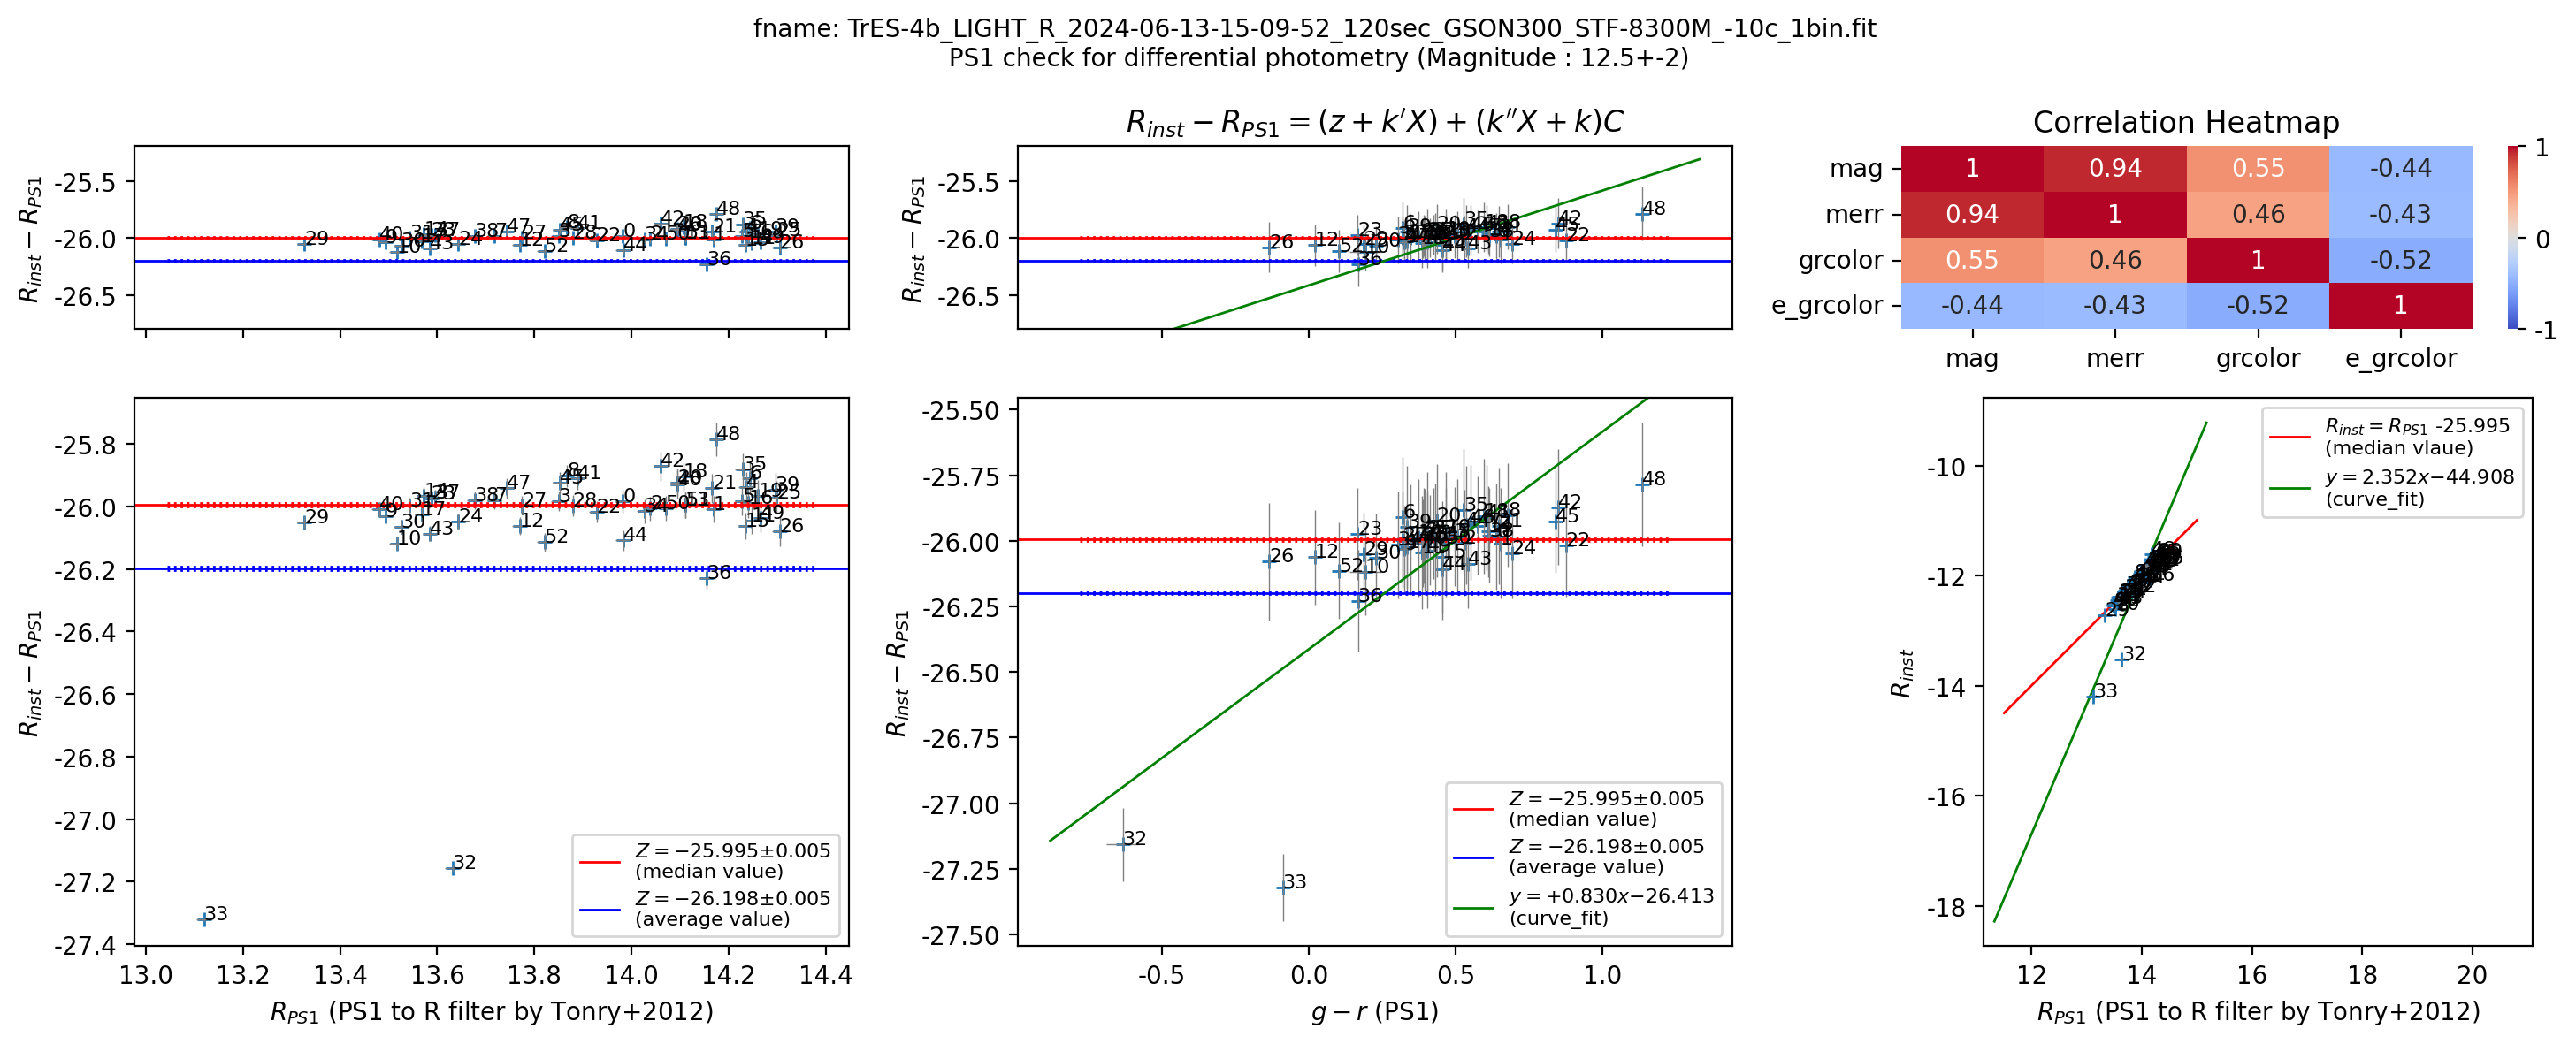

In [69]:
import seaborn as sns

fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharex=False, sharey=False,
        gridspec_kw={'height_ratios': [1, 3]})
errkw = dict(marker="", ls="", ecolor="gray", elinewidth=0.5)

def plot_common(ax, x, y, xerr, yerr, title="", xlabel="", ylabel="", ylim=None):
    ax.plot(x, y, '+')
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, **errkw)
    ax.axhline(zeropt_med, color="r", lw=1, label=f"$Z = {{{zeropt_med:.3f}}} ± {{{dzeropt:.3f}}}$\n(median value)")
    ax.axhline(zeropt_avg, color="b", lw=1, label=f"$Z = {{{zeropt_avg:.3f}}} ± {{{dzeropt:.3f}}}$\n(average value)")
    ax.hlines([zeropt_med + dzeropt, zeropt_med - dzeropt, zeropt_avg + dzeropt, zeropt_avg - dzeropt],
            *ax.get_xlim(), color=["r","r","b","b"], lw=1, ls=":")
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel, ylim=ylim)
    # ax.legend(fontsize=8, loc='best')

# 상단 행
plot_common(axs[0, 0], df_phot_stars_na[f"{flt}mag"], df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"],
            df_phot_stars_na[f"e_{flt}mag"], df_phot_stars_na["merr"],
            ylabel=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}}$",
            ylim=(zeropt_med-0.8, zeropt_med+0.8))

plot_common(axs[0, 1], df_phot_stars_na["grcolor"], df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"],
            df_phot_stars_na[f"e_grcolor"], merr_total2,
            title=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}} = (z + k'X) + (k''X + k)C$",
            ylabel=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}}$",
            ylim=(zeropt_med-0.8, zeropt_med+0.8))
axs[0, 1].plot(axs[0, 1].get_xlim(), linf(np.array(axs[0, 1].get_xlim()), *poptc),
            "g-", lw=1, label=f"$y = {{{poptc[1]:+.3f}}}x {{{poptc[0]:+.3f}}}$\n(curve_fit)")
# axs[0, 1].legend(fontsize=8, loc='best')

data = df_phot_stars_na[["mag", "merr", "grcolor", "e_grcolor"]]
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, ax=axs[0, 2])
axs[0, 2].set(title='Correlation Heatmap')

# 하단 행
plot_common(axs[1, 0], df_phot_stars_na[f"{flt}mag"], df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"],
            df_phot_stars_na[f"e_{flt}mag"], df_phot_stars_na["merr"],
            xlabel=f"${{{flt}}}_{{PS1}}$ (PS1 to {flt} filter by Tonry+2012)",
            ylabel=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}}$")

plot_common(axs[1, 1], df_phot_stars_na["grcolor"], df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"],
            df_phot_stars_na[f"e_grcolor"], merr_total2,
            xlabel="$g - r$ (PS1)",
            ylabel=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}}$")
axs[1, 0].legend(fontsize=8, loc='best')

axs[1, 1].plot(axs[1, 1].get_xlim(), linf(np.array(axs[1, 1].get_xlim()), *poptc),
            "g-", lw=1, label=f"$y = {{{poptc[1]:+.3f}}}x {{{poptc[0]:+.3f}}}$\n(curve_fit)")
axs[1, 1].legend(fontsize=8, loc='best')

axs[1, 2].plot(_xx, _xx + zeropt_med,
            label=f"${{{flt}}}_{{inst}} = {{{flt}}}_{{PS1}}$ {zeropt_med:+.03f}\n(median vlaue)",
            color="r", lw=1, ls="-")
axs[1, 2].plot(axs[1, 2].get_xlim(), linf(np.array(axs[1, 2].get_xlim()), *poptm),
            "g-", lw=1, label=f"$y = {{{poptm[1]:.3f}}}x {{{poptm[0]:+.3f}}}$\n(curve_fit)")
axs[1, 2].plot(df_phot_stars_na[f"{flt}mag"], df_phot_stars_na["mag"], '+')
axs[1, 2].errorbar(df_phot_stars_na[f"{flt}mag"],
            df_phot_stars_na["mag"],
            xerr=df_phot_stars_na[f"e_{flt}mag"],
            yerr=df_phot_stars_na["merr"],
            **errkw)
axs[1, 2].set(
            xlabel=f"${{{flt}}}_{{PS1}}$ (PS1 to {flt} filter by Tonry+2012)",
            ylabel =f"${{{flt}}}_{{inst}}$",
        )
axs[1, 2].legend(fontsize=8, loc='best')
axs[1, 2].axis('square')

# ID 텍스트 추가
for _, row in df_phot_stars_na.iterrows():
    for i in range(2):
        for j in range(2):
            axs[i, j].text(row[f"{flt}mag" if j == 0 else "grcolor"],
                        row["mag"] - row[f"{flt}mag"], int(row["id"]), fontsize=8, clip_on=True)
    axs[1, 2].text(row[f"{flt}mag"], row["mag"], int(row["id"]), fontsize=8, clip_on=True)

# x축 레이블 숨기기 (상단 행)
for ax in axs[0, :2]:
    ax.tick_params(labelbottom=False)

plt.suptitle(f"fname: {fpath.name}\n PS1 check for differential photometry (Magnitude : {Mag_target}+-{Mag_delta})", fontsize=10)
plt.tight_layout()
plt.savefig(f"{BASEPATH / save_dir_name}/{fpath.stem}_standardization_extended.png")

plt.show()

## 모든 별 측광

### 별 찾기

In [70]:
from astropy.stats import sigma_clipped_stats

FWHM = FWHM_INIT
avg, med, std = sigma_clipped_stats(hdul[0].data)  # by default, 3-sigma 5-iteration.
thresh = 5. * std

from photutils.detection import DAOStarFinder
DAOfind = DAOStarFinder(
                        fwhm = FWHM,
                        threshold=thresh,   # In reality, FWHM must be measured a priori using, e.g., ``ginga``
                        # sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
                        # roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                        # sigma_radius=1.5,           # default values 1.5
                        # ratio=1.0,                  # 1.0: circular gaussian
                        exclude_border=True         # To exclude sources near edges
                        )

DAOfound = DAOfind(hdul[0].data)
print("len(DAOfound) :",len(DAOfound))
print(DAOfound.colnames)

df_DAO = DAOfound.to_pandas()
print(type(df_DAO))
df_DAO

pos = np.transpose((DAOfound['xcentroid'], DAOfound['ycentroid']))
apert = CAp(pos, r=R_AP)
annul = CAn(positions=pos, r_in= R_IN, r_out=R_OUT)


len(DAOfound) : 561
['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']
<class 'pandas.core.frame.DataFrame'>


### tag on image

In [71]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8),
                        subplot_kw={'projection': wcs},
                        sharex=False, sharey=False, gridspec_kw=None)

im = zimshow(axs, hdul[0].data, )
axs.set_title('World coordinate system', fontsize=9)
axs.coords.grid(True, color='white', ls=':')
axs.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
axs.coords['ra'].set_ticklabel_position('bl')
axs.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
axs.coords['dec'].set_ticklabel_position('bl')
axs.coords['ra'].set_major_formatter('hh:mm')
axs.coords['dec'].set_major_formatter('dd:mm')
axs.coords['ra'].display_minor_ticks(True)
axs.coords['dec'].display_minor_ticks(True)
axs.coords['ra'].set_minor_frequency(2)
axs.coords['dec'].set_minor_frequency(2)
axs.tick_params(labelsize=8)

annul.plot(axs, color="r")
for i in range(len(pos)):
    axs.text(pos[i][0], pos[i][1], f"Star #{str(i)}", fontsize=6, color='w')

annul.plot(axs, color="r")

cbar = plt.colorbar(im, ax = axs, fraction=0.035, pad=0.04, )
cbar.ax.tick_params(labelsize=8)

axs.set_title(f"fname: {fpath.name}\n Result of DAOFinder", fontsize=10,)

axs.annotate(f'FWHM: {FWHM}', fontsize=8,
    xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

axs.annotate(f'Sky threshold: {thresh:.02f}', fontsize=8,
    xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

axs.annotate(f'Number of star(s): {len(DAOfound)}', fontsize=8,
    xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{save_dir_name}/{fpath.stem}_DAOStarfinder_fwhm_{FWHM}.png")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

### sky estimation

In [72]:
import numpy as np
from astropy.stats import sigma_clip

def sky_fit(all_sky, method='mode', sky_nsigma=3, sky_iter=5, \
            mode_option='sex', med_factor=2.5, mean_factor=1.5):
    '''
    Estimate sky from given sky values.
    Parameters
    ----------
    all_sky : ~numpy.ndarray
        The sky values as numpy ndarray format. It MUST be 1-d for proper use.
    method : {"mean", "median", "mode"}, optional
        The method to estimate sky value. You can give options to "mode"
        case; see mode_option.
        "mode" is analogous to Mode Estimator Background of photutils.
    sky_nsigma : float, optinal
        The input parameter for sky sigma clipping.
    sky_iter : float, optinal
        The input parameter for sky sigma clipping.
    mode_option : {"sex", "IRAF", "MMM"}, optional.
        sex  == (med_factor, mean_factor) = (2.5, 1.5)
        IRAF == (med_factor, mean_factor) = (3, 2)
        MMM  == (med_factor, mean_factor) = (3, 2)
    Returns
    -------
    sky : float
        The estimated sky value within the all_sky data, after sigma clipping.
    std : float
        The sample standard deviation of sky value within the all_sky data,
        after sigma clipping.
    nsky : int
        The number of pixels which were used for sky estimation after the
        sigma clipping.
    nrej : int
        The number of pixels which are rejected after sigma clipping.
    -------
    '''
    sky = all_sky.copy()
    if method == 'mean':
        return np.mean(sky), np.std(sky, ddof=1)

    elif method == 'median':
        return np.median(sky), np.std(sky, ddof=1)

    elif method == 'mode':
        sky_clip   = sigma_clip(sky, sigma=sky_nsigma,
                                maxiters=sky_iter, #iters=sky_iter,
                                )
        sky_clipped= sky[np.invert(sky_clip.mask)]
        nsky       = np.count_nonzero(sky_clipped)
        mean       = np.mean(sky_clipped)
        med        = np.median(sky_clipped)
        std        = np.std(sky_clipped, ddof=1)
        nrej       = len(all_sky) - len(sky_clipped)

        if nrej < 0:
            raise ValueError('nrej < 0: check the code')

        if nrej > nsky: # rejected > survived
            raise Warning('More than half of the pixels rejected.')

        if mode_option == 'IRAF':
            if (mean < med):
                sky = mean
            else:
                sky = 3 * med - 2 * mean

        elif mode_option == 'MMM':
            sky = 3 * med - 2 * mean

        elif mode_option == 'sex':
            if (mean - med) / std > 0.3:
                sky = med
            else:
                sky = (2.5 * med) - (1.5 * mean)
        else:
            raise ValueError('mode_option not understood')

        return sky, std, nsky, nrej

### 측광 수행하여 결과 저장하기

In [73]:
def mag_inst(flux, ferr):
    m_inst = -2.5 * np.log10(flux)
    merr   = 2.5/ np.log(10) * ferr / flux
    return m_inst, merr

from photutils.aperture import aperture_photometry as apphot

apphot_result = apphot(hdul[0].data, apert, method='center')
print(type(apphot_result))
# df_apphot = pd.DataFrame()
# apphot_result
df_apphot = apphot_result.to_pandas()
print(type(df_apphot))
df_apphot

ap_area  = apert.area
ap_area

# since our `annul` has many elements,
mask_apert = (apert.to_mask(method='center'))
mask_annul = (annul.to_mask(method='center'))

mag_ann  = np.zeros(len(apphot_result))
merr_ann = np.zeros(len(apphot_result))

<class 'astropy.table.table.QTable'>
<class 'pandas.core.frame.DataFrame'>


In [74]:
for i in range(len(apphot_result)):
    annul_weighted = mask_annul[i].multiply(hdul[0].data)
    sky_non0   = np.nonzero(annul_weighted)
    sky_pixel  = annul_weighted[sky_non0]

    msky, sky_std, nsky, nrej = sky_fit(sky_pixel, method='mode',
                                                        mode_option='sex')


    flux_star = apphot_result['aperture_sum'][i] - msky * ap_area  # total - sky

    flux_err  = np.sqrt(apphot_result['aperture_sum'][i] * gain    # Poissonian (star + sky)
                        + ap_area * rdnoise**2 # Gaussian
                        + (ap_area * (gain * sky_std))**2 / nsky )

    mag_ann[i], merr_ann[i] = mag_inst(flux_star, flux_err)
    df_apphot.at[i, 'msky'] = msky
    df_apphot.at[i, 'sky_std'] = sky_std
    df_apphot.at[i, 'nsky'] = nsky
    df_apphot.at[i, 'nrej'] = nrej
    df_apphot.at[i, 'flux_star'] = flux_star
    df_apphot.at[i, 'flux_err'] = flux_err
    df_apphot.at[i, 'mag_ann'] = mag_ann[i]
    df_apphot.at[i, 'merr_ann'] = merr_ann[i]

df_apphot['filename'] = fpath.stem
df_apphot['t_start'] = t_start
df_apphot['t_expos'] = t_expos
df_apphot['t_middle'] = t_middle
df_apphot['filter'] = flt
df_apphot["zeropt_med"] = zeropt_med
df_apphot["zeropt_avg"] = zeropt_avg
df_apphot["e_zeropt"] = dzeropt

df_apphot[f"{flt}_magnitude"] = df_apphot["mag_ann"] - df_apphot["zeropt_med"]

sky_coord = wcs.pixel_to_world(df_apphot['xcenter'], df_apphot['ycenter'])
sky_coord
print(type(sky_coord))

df_RADEC = pd.DataFrame({"RAJ2000": sky_coord.ra.degree, "DEJ2000": sky_coord.dec.degree})
df_apphot = pd.concat([df_apphot, df_RADEC], axis=1,)

df_apphot['filename'] = fpath.stem
df_apphot['t_start'] = t_start
df_apphot['t_expos'] = t_expos
df_apphot['t_middle'] = t_middle
df_apphot['filter'] = flt
df_apphot["zeropt_med"] = zeropt_med
df_apphot["zeropt_avg"] = zeropt_avg
df_apphot["e_zeropt"] = dzeropt
df_apphot[f"{flt}_magnitude"] = df_apphot["mag_ann"] - df_apphot["zeropt_med"]

df_apphot.to_csv(f"{save_dir_name}/{fpath.stem}_result_photometry.csv")

<class 'astropy.coordinates.sky_coordinate.SkyCoord'>


###(과제)

df_apphot에 들어 있는 각 컬럼의 데이터는 무엇인지 그 설명을 쓰시오. (아래에 이어서 작성하시오.)


* id : 별의 id  
* xcenter : 별의 픽셀 좌표 x
* ycenter : 별의 픽셀 좌표 y    float64
* aperture_sum : 구경 안의 픽셀 값의 합 (starlight + skylight)
*  
*


In [75]:
print(df_apphot.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            561 non-null    int64  
 1   xcenter       561 non-null    float64
 2   ycenter       561 non-null    float64
 3   aperture_sum  561 non-null    float64
 4   msky          561 non-null    float64
 5   sky_std       561 non-null    float64
 6   nsky          561 non-null    float64
 7   nrej          561 non-null    float64
 8   flux_star     561 non-null    float64
 9   flux_err      561 non-null    float64
 10  mag_ann       540 non-null    float64
 11  merr_ann      561 non-null    float64
 12  filename      561 non-null    object 
 13  t_start       561 non-null    object 
 14  t_expos       561 non-null    float64
 15  t_middle      561 non-null    object 
 16  filter        561 non-null    object 
 17  zeropt_med    561 non-null    float64
 18  zeropt_avg    561 non-null    

### 측광 결과 분석

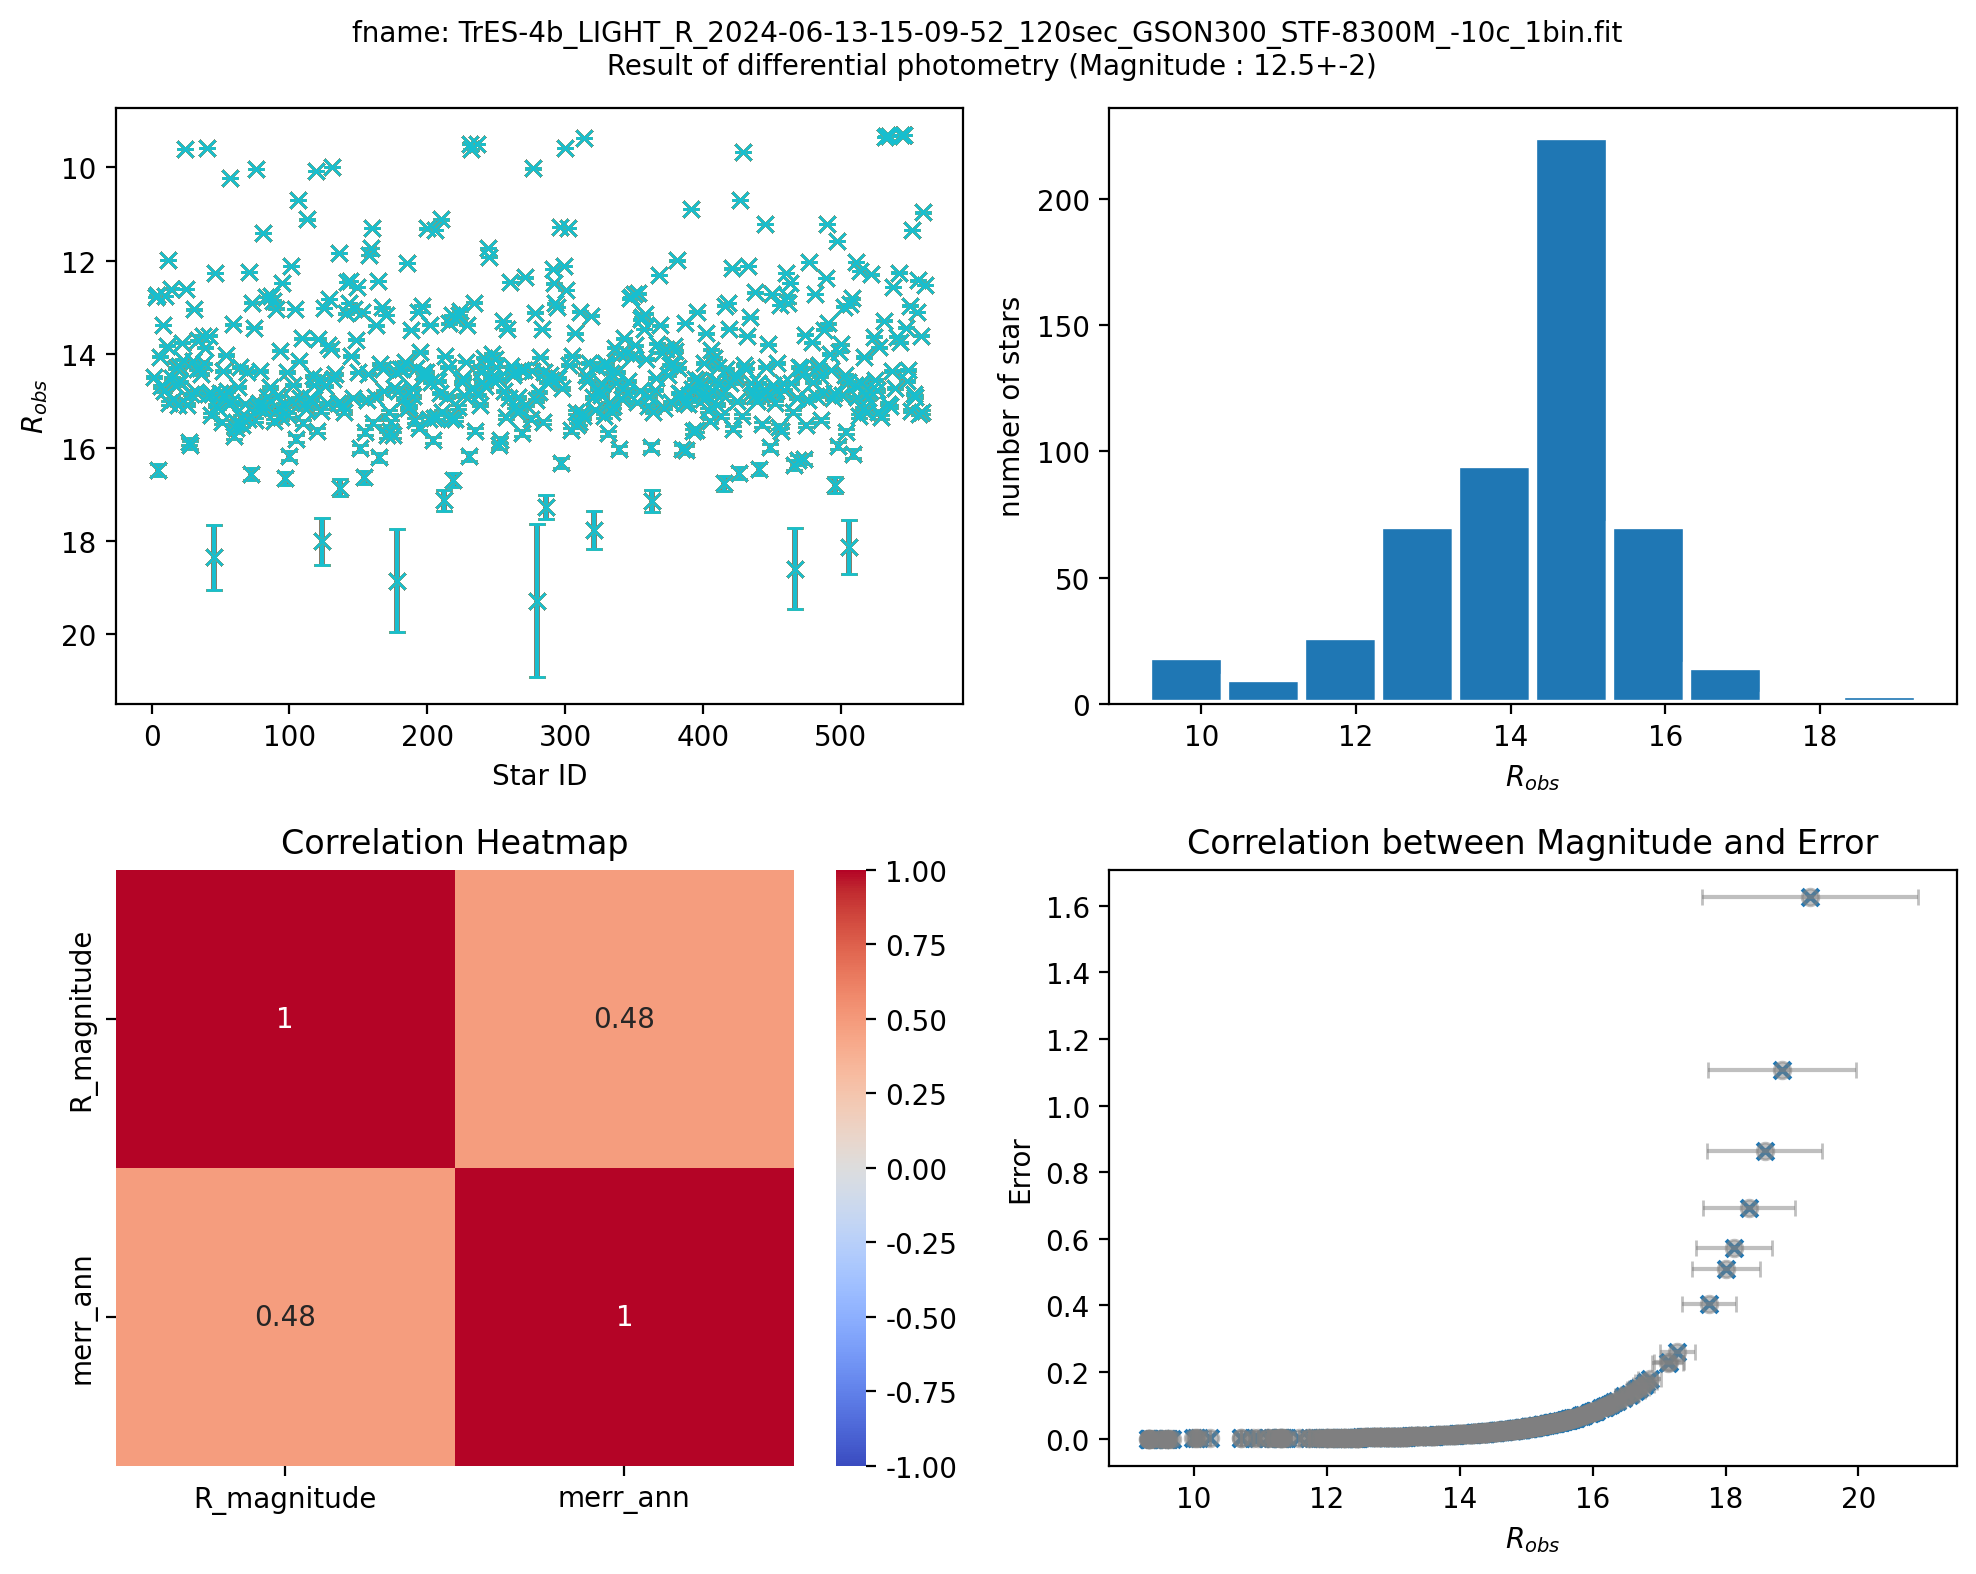

In [76]:
df_apphot_sub = df_apphot.dropna()
df_apphot_sub

fig, axs = plt.subplots(2, 2, figsize=(10, 8),
                        sharex=False, sharey=False, gridspec_kw=None)

for idx, row in df_apphot_sub.iterrows():
    im0 = axs[0, 0].errorbar(df_apphot_sub["id"],
                df_apphot_sub[f"{flt}_magnitude"], yerr=df_apphot_sub["merr_ann"],
                marker='x',
                ls='none',
                #ms=10,
                capsize=3)

axs[0, 0].invert_yaxis()
axs[0, 0].set(
    xlabel='Star ID',
    ylabel=f"${{{flt}}}_{{obs}}$"
    )

style = {'edgecolor': 'white', 'linewidth': 3}
im1 = axs[0, 1].hist(df_apphot_sub[f"{flt}_magnitude"],
            **style)
axs[0, 1].set(
    xlabel=f"${{{flt}}}_{{obs}}$",
    ylabel="number of stars"
    )

# 상관관계 계산
data =  df_apphot_sub[[f"{flt}_magnitude", "merr_ann"]]
corr = data.corr()

# 히트맵 그리기
im2 = sns.heatmap(corr, annot=True, cmap='coolwarm',
                    vmin=-1, vmax=1, center=0, ax = axs[1, 0])
axs[1, 0].set(
    title = 'Correlation Heatmap',
    )

axs[1, 1].scatter(df_apphot_sub[f"{flt}_magnitude"], df_apphot_sub["merr_ann"], marker='x',)
axs[1, 1].errorbar(x=df_apphot_sub[f"{flt}_magnitude"], y=df_apphot_sub["merr_ann"],
            yerr=None, xerr=df_apphot_sub["merr_ann"], fmt="o", color="gray", capsize=3, alpha=0.5)
axs[1, 1].set(
    title = "Correlation between Magnitude and Error",
    xlabel=f"${{{flt}}}_{{obs}}$",
    ylabel="Error",
    )

plt.suptitle(f"fname: {fpath.name}\n Result of differential photometry (Magnitude : {Mag_target}+-{Mag_delta})", fontsize=10,)

plt.tight_layout()
plt.savefig(f"{save_dir_name}/{fpath.stem}_Result_of_differential_photometry.png")

plt.show()
# plt.close()

### (과제)

아래 index의 별을 제거 후 zero point를 구하여 표준화를 수행하시오.

mask_idx = [32, 33, 36, 48, 42, 45, 26]

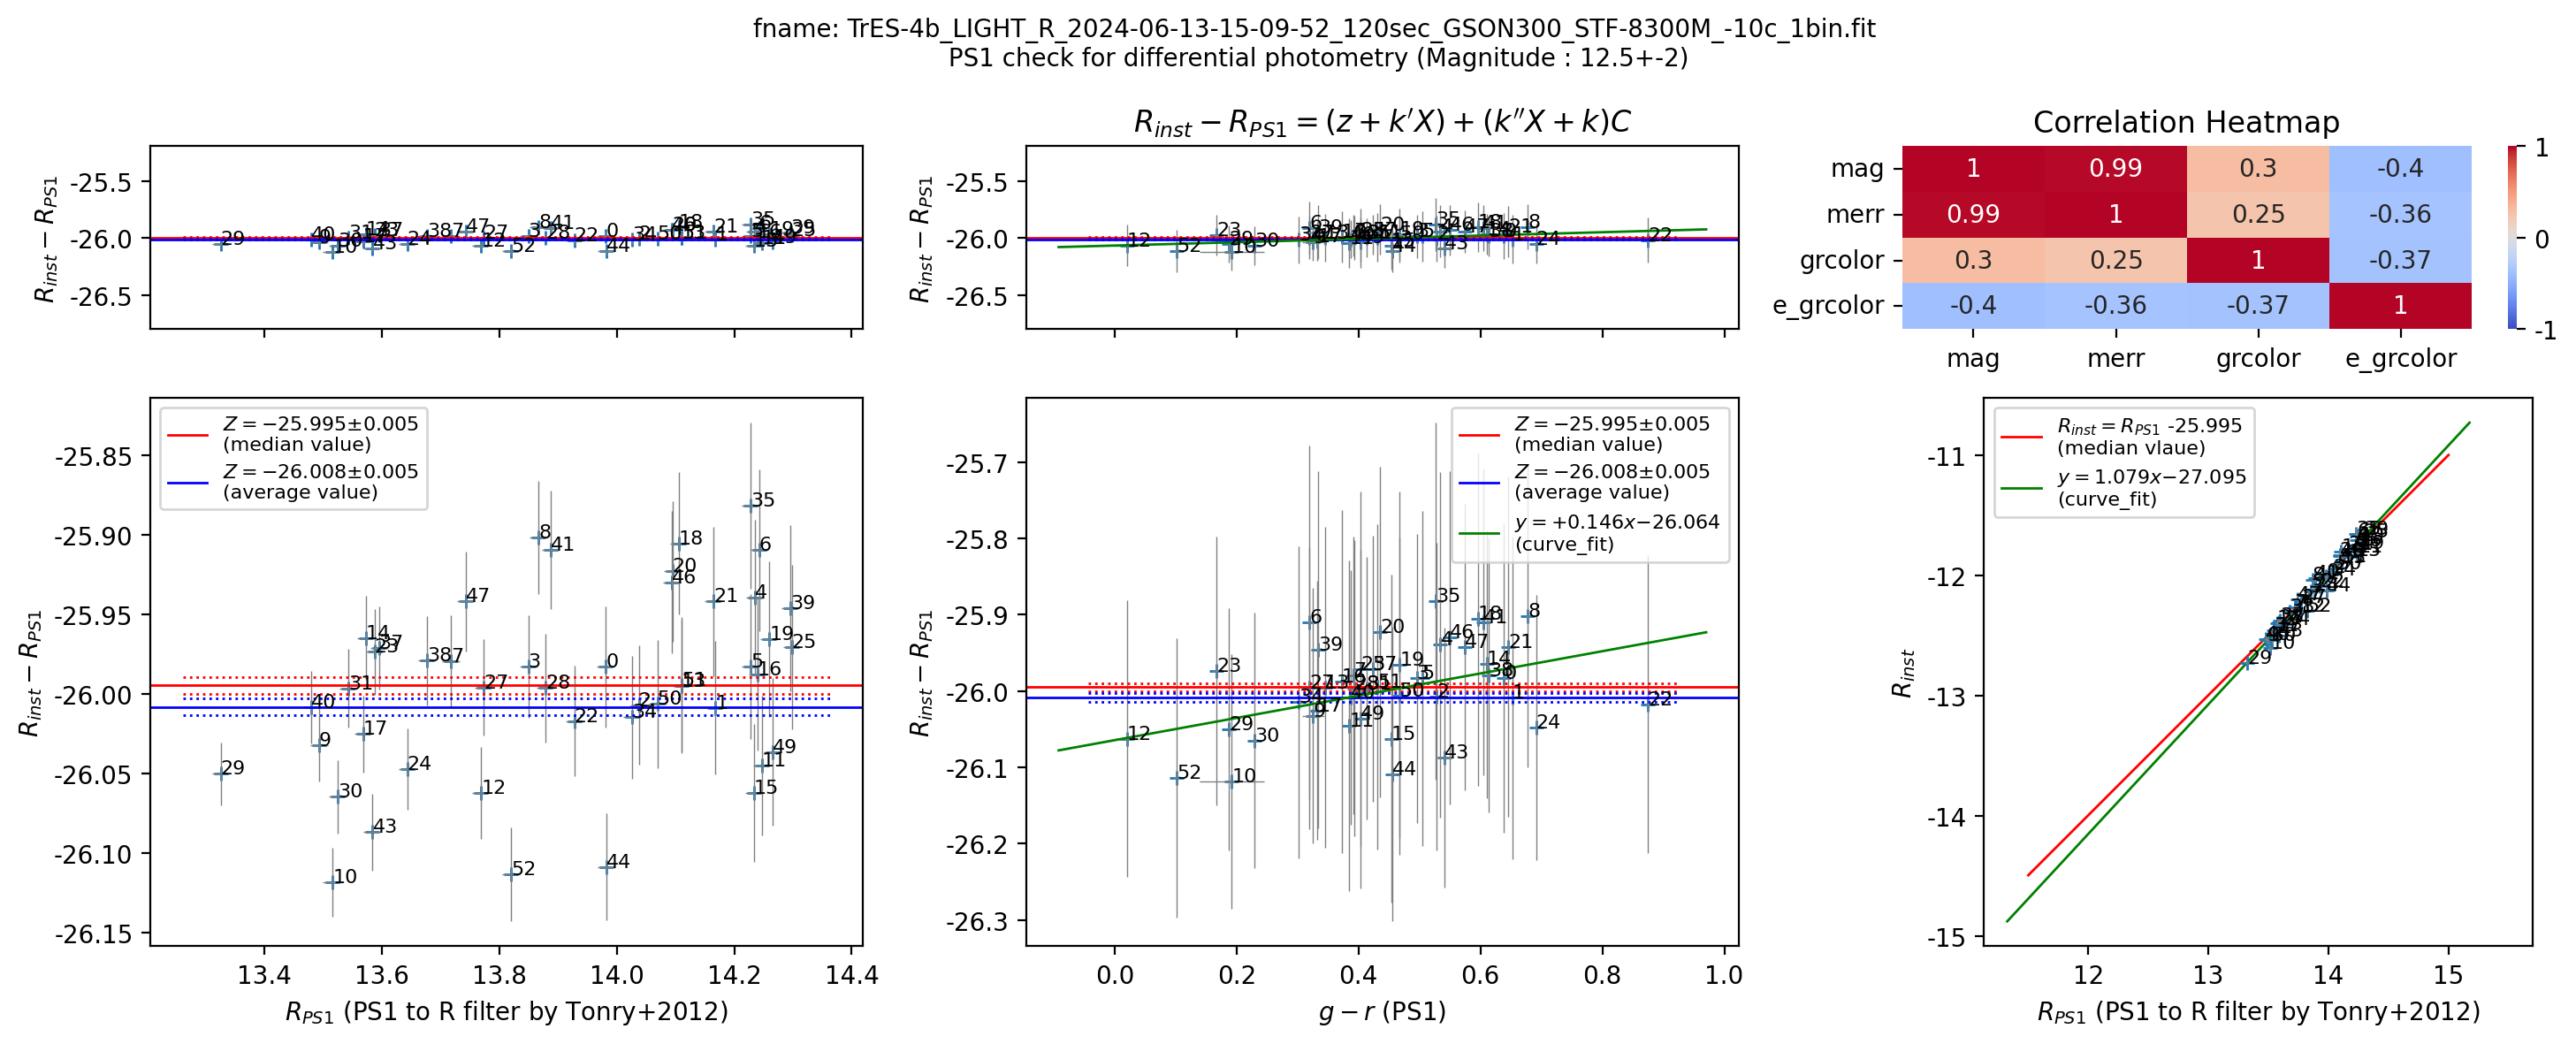

In [77]:
mask_idx = [32, 33, 36, 48, 42, 45, 26]
# mask = df_phot_stars_na[df_phot_stars_na.id.isin(mask_idx)]
mask = df_phot_stars_na['id'].isin(mask_idx)
# print("mask :",mask)

In [78]:
#(과제) 아래에 코딩을 완성하여 제출하시오.
df_phot_stars_na_filter = df_phot_stars_na[~mask]
df_phot_stars_na_filter

merr_total1 = np.sqrt((df_phot_stars_na_filter["merr"])**2 + (df_phot_stars_na_filter[f"e_{flt}mag"])**2)

# === Calculate zero point and errors
_xx = np.linspace(Mag_Low, Mag_High)
zeropt_med = np.median(df_phot_stars_na_filter["mag"] - df_phot_stars_na_filter[f"{flt}mag"])
zeropt_avg = np.average(df_phot_stars_na_filter["mag"] - df_phot_stars_na_filter[f"{flt}mag"],
                        weights=1/merr_total1**2)
dzeropt = np.max([1/np.sqrt(np.sum(1/(merr_total1)**2)),
                  np.std((df_phot_stars_na_filter[f"e_{flt}mag"] - df_phot_stars_na_filter["merr"]), ddof=1)/np.sqrt(len(df_phot_stars_na_filter[f"{flt}mag"]))])
merr_total2 = np.sqrt(np.sqrt(merr_total1**2 + dzeropt**2))

# === Find fitting lines
# Search for the usage of scipy.optimize.curve_fit.
poptm, _ = curve_fit(linf, df_phot_stars_na_filter[f"{flt}mag"],
                     df_phot_stars_na_filter["mag"],
                     sigma= df_phot_stars_na_filter["merr"], absolute_sigma=True)
poptc, _ = curve_fit(linf, df_phot_stars_na_filter["grcolor"],
                     df_phot_stars_na_filter["mag"] - df_phot_stars_na_filter[f"{flt}mag"],
                     sigma=merr_total2, absolute_sigma=True)












##(과제)

차등 측광 결과로 저장한 csv 파일을 읽어 dataframe을 만들어 출력하시오.

In [79]:
df_result = pd.read_csv(f"{save_dir_name}/{fpath.stem}_result_photometry.csv")
df_result

,Unnamed: 0,id,xcenter,ycenter,aperture_sum,msky,sky_std,nsky,nrej,flux_star,...,t_start,t_expos,t_middle,filter,zeropt_med,zeropt_avg,e_zeropt,R_magnitude,RAJ2000,DEJ2000
0,0,1,943.742194,7.219668,1.263688e+06,4979.925854,120.173185,1318.0,3.0,-3.548762e+03,...,2024-06-13T15:09:52.375,120.0,2024-06-13T15:10:52.375,R,-25.995165,-26.198397,0.004772,NaN,268.576320,37.537575
1,1,2,1557.819612,8.716972,1.305866e+06,4973.606654,117.930530,1349.0,5.0,4.023705e+04,...,2024-06-13T15:09:52.375,120.0,2024-06-13T15:10:52.375,R,-25.995165,-26.198397,0.004772,14.483599,268.379031,37.538716
2,2,3,1016.296773,12.401798,1.460322e+06,4982.008517,124.066841,1431.0,20.0,1.925548e+05,...,2024-06-13T15:09:52.375,120.0,2024-06-13T15:10:52.375,R,-25.995165,-26.198397,0.004772,12.783779,268.552993,37.536452
3,3,4,1975.037138,14.092487,1.462485e+06,4952.651535,121.338881,1488.0,8.0,2.021887e+05,...,2024-06-13T15:09:52.375,120.0,2024-06-13T15:10:52.375,R,-25.995165,-26.198397,0.004772,12.730773,268.244973,37.538193
4,4,5,1212.974534,16.865165,1.272295e+06,4974.474930,121.927338,1562.0,16.0,6.444999e+03,...,2024-06-13T15:09:52.375,120.0,2024-06-13T15:10:52.375,R,-25.995165,-26.198397,0.004772,16.472108,268.489793,37.535826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,556,557,1250.094336,2494.926943,1.257820e+06,4866.541782,116.596769,2253.0,8.0,1.943583e+04,...,2024-06-13T15:09:52.375,120.0,2024-06-13T15:10:52.375,R,-25.995165,-26.198397,0.004772,15.273657,268.469900,36.904587
557,557,558,3302.251529,2498.295998,1.357542e+06,4979.544819,126.653146,2200.0,10.0,9.040209e+04,...,2024-06-13T15:09:52.375,120.0,2024-06-13T15:10:52.375,R,-25.995165,-26.198397,0.004772,13.604718,267.816087,36.906970
558,558,559,2394.872479,2498.856527,1.257658e+06,4863.117030,120.451364,2186.0,8.0,2.014515e+04,...,2024-06-13T15:09:52.375,120.0,2024-06-13T15:10:52.375,R,-25.995165,-26.198397,0.004772,15.234739,268.105173,36.905836
559,559,560,713.194754,2512.254472,2.267929e+06,4893.481083,122.583509,1633.0,3.0,1.022690e+06,...,2024-06-13T15:09:52.375,120.0,2024-06-13T15:10:52.375,R,-25.995165,-26.198397,0.004772,10.970804,268.640878,36.898734
